In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

In [2]:
data = pd.read_csv(r"C:\Users\Haripriya\Documents\Final_project\Data\jobs.csv")
print(data.head())

   Unnamed: 0                    Job Salary Job Experience Required  \
0           0   Not Disclosed by Recruiter               5 - 10 yrs   
1           1   Not Disclosed by Recruiter                2 - 5 yrs   
2           2   Not Disclosed by Recruiter                0 - 1 yrs   
3           3       2,00,000 - 4,00,000 PA.               0 - 5 yrs   
4           4   Not Disclosed by Recruiter                2 - 5 yrs   

                                          Key Skills  \
0                      Media Planning| Digital Media   
1   pre sales| closing| software knowledge| clien...   
2   Computer science| Fabrication| Quality check|...   
3                                  Technical Support   
4   manual testing| test engineering| test cases|...   

                                Role Category  \
0                                 Advertising   
1                                Retail Sales   
2                                         R&D   
3  Admin/Maintenance/Security/Datawareho

In [3]:
data = data.drop("Unnamed: 0",axis=1)

C:\Users\Haripriya\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Epoch 1/10
676/676 [==============================] - 15s 18ms/step - loss: 1.9378 - accuracy: 0.6475 - val_loss: 0.9105 - val_accuracy: 0.8414
Epoch 2/10
676/676 [==============================] - 12s 18ms/step - loss: 0.5403 - accuracy: 0.9032 - val_loss: 0.4545 - val_accuracy: 0.9239
Epoch 3/10
676/676 [==============================] - 12s 18ms/step - loss: 0.2584 - accuracy: 0.9469 - val_loss: 0.4086 - val_accuracy: 0.9176
Epoch 4/10
676/676 [==============================] - 12s 18ms/step - loss: 0.1524 - accuracy: 0.9658 - val_loss: 0.3171 - val_accuracy: 0.9495
Epoch 5/10
676/676 [==============================] - 13s 19ms/step - loss: 0.1060 - accuracy: 0.9740 - val_loss: 0.3101 - val_accuracy: 0.9530
Epoch 6/10
676/676 [==============================] - 12s 18ms/step - loss: 0.0807 - accuracy: 0.9791 - val_loss: 0.3224 - val_accuracy: 0.9506
Epoch 7/10
676/676 [==============================] - 12s 18ms/step - loss: 0.0672 - accuracy: 0.9819 - val_loss: 0.3256 - val_accuracy:

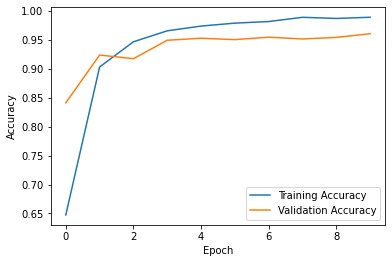

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


job_data = data["Job Title"] + " " + data["Key Skills"] + " " + data["Job Experience Required"]


job_data_words = job_data.apply(lambda x: x.split())


word2vec_model = Word2Vec(job_data_words, vector_size=50, window=5, sg=1, min_count=1)  


word_embeddings = []
for job_words in job_data_words:
    job_embedding = [word2vec_model.wv[word] for word in job_words if word in word2vec_model.wv]
    word_embeddings.append(job_embedding)


max_sequence_length = 200  
job_data_matrix_padded = pad_sequences(word_embeddings, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["Job Title"])

n_classes = len(data["Job Title"].unique())


X_train, X_test, y_train, y_test = train_test_split(job_data_matrix_padded, y, test_size=0.2, random_state=42)


model = keras.Sequential([
    layers.Input(shape=(200, 50)),  
    layers.Flatten(),  
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:
import io
import pandas as pd
import spacy
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage


def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as fh:
        
        for page in PDFPage.get_pages(fh, caching=True, check_extractable=True):
            
            resource_manager = PDFResourceManager()

            
            fake_file_handle = io.StringIO()

            
            converter = TextConverter(
                resource_manager,
                fake_file_handle,
                laparams=LAParams()
            )

            
            page_interpreter = PDFPageInterpreter(
                resource_manager,
                converter
            )

            
            page_interpreter.process_page(page)

            
            text += fake_file_handle.getvalue()

           
            converter.close()
            fake_file_handle.close()
    return text


nlp = spacy.load('en_core_web_md')  

def extract_skills_from_pdf(pdf_path, skills_csv):
    
    resume_text = extract_text_from_pdf(pdf_path)

    
    nlp_text = nlp(resume_text)
    tokens = [token.text for token in nlp_text if not token.is_stop]

    
    skills_data = pd.read_csv(skills_csv)
    skills = skills_data['Skill'].str.lower().tolist()

    skillset = []

    
    for token in tokens:
        if token.lower() in skills:
            skillset.append(token)

    
    for token in nlp_text.noun_chunks:
        token = token.text.lower().strip()
        if token in skills:
            skillset.append(token)

    return [i.capitalize() for i in set([i.lower() for i in skillset])]


file_path = 'SATHISH KUMAR K RESUME.pdf'
csv_path = 'skills.csv'

text = extract_text_from_pdf(file_path)
print(text)

result = extract_skills_from_pdf(file_path, csv_path)
print(result)


SATHISH KUMAR K  Aspiring Data Scientist

sendtosathishkumark@gmail.com

+91 9677084638

Sathish kumar karunakaran

Professional Summary

Results-driven  engineer  with  a  Data  Science  Professional  Degree  Certification.  Proficient  in  advanced
analytical  techniques  for  extracting  actionable  business  insights.  Seeking  entry-level  Data  Analyst  or
Data Scientist role to apply diverse data mining and analysis skills. Committed to enhancing corporate
performance and achieving ambitious data science career goals.

Programming Languages
Python

Technical Skills
Data Manipulation Analysis
Pandas, NumPy

Data Visualization
Matplotlib, Seaborn, Plotly

Machine Learning
Supervised and Unsupervised 
Algorithms

Mathematical Analysis:
Statistical analysis, Probability 
theory, Algebra, Calculus

Database Languages
SQL (MySQL), NoSQL (MongoDB, 
Cassandra)

Natural Language Processing
NLTK, Hugging Face

Business Intelligence
Power BI, EDA, Charts, DAX

Cloud Platforms
Amazon Web Se

In [6]:

job_title = input("Enter the job title: ")

skills = result

print("Select Experience Range:")
print("1. 5 - 10 yrs")
print("2. 2 - 5 yrs")
print("3. 0 - 1 yrs")
print("4. 0 - 5 yrs")
print("5. 2 - 5 yrs")
print("6. 5 - 7 yrs")
print("7. 0 - 0 yrs")
print("8. 9 - 14 yrs")
print("9. 2 - 7 yrs")
print("10. 1 - 5 yrs")
print("11. 5 - 10 yrs")
print("12. 1 - 6 yrs")
print("13. 2 - 7 yrs")
experience_option = input("Enter the number of the experience range: ")

experience_ranges = [
    "5 - 10 yrs",
    "2 - 5 yrs",
    "0 - 1 yrs",
    "0 - 5 yrs",
    "2 - 5 yrs",
    "5 - 7 yrs",
    "0 - 0 yrs",
    "9 - 14 yrs",
    "2 - 7 yrs",
    "1 - 5 yrs",
    "5 - 10 yrs",
    "1 - 6 yrs",
    "2 - 7 yrs"
]

experience = experience_ranges[int(experience_option) - 1]

input_data = [f"{job_title}| {skills}| {experience}"]

print("Input Data:", input_data)


Enter the job title: Data scientist
Select Experience Range:
1. 5 - 10 yrs
2. 2 - 5 yrs
3. 0 - 1 yrs
4. 0 - 5 yrs
5. 2 - 5 yrs
6. 5 - 7 yrs
7. 0 - 0 yrs
8. 9 - 14 yrs
9. 2 - 7 yrs
10. 1 - 5 yrs
11. 5 - 10 yrs
12. 1 - 6 yrs
13. 2 - 7 yrs
Enter the number of the experience range: 2
Input Data: ["Data scientist| ['Matplotlib', 'Supervised', 'Unsupervised', 'Algebra', 'Charts', 'Dax', 'Seaborn', 'Algorithms', 'Nltk', 'Eda', 'Python', 'Calculus', 'Pandas', 'Numpy', 'Statistical analysis', 'Plotly']| 2 - 5 yrs"]


In [7]:
input_data_words = [text.split() for text in input_data]


input_data_embeddings = []
for words in input_data_words:
    input_embedding = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    input_data_embeddings.append(input_embedding)


input_data_matrix_padded = pad_sequences(input_data_embeddings, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')


predictions = model.predict(input_data_matrix_padded)

top_indices = predictions.argsort()[0, -5:][::-1]
top_job_titles = label_encoder.classes_[top_indices]
matching_percentages = predictions[0, top_indices] * 100

for title, percentage in zip(top_job_titles, matching_percentages):
    print(f"Recommended Job Title: {title}, Matching Percentage: {percentage:.2f}%")

1/1 [==============================] - 0s 156ms/step
Recommended Job Title: Data Analyst, Matching Percentage: 100.00%
Recommended Job Title: Database Architect/Designer, Matching Percentage: 0.00%
Recommended Job Title: DBA, Matching Percentage: 0.00%
Recommended Job Title: Leading LOGISTICS FIRM, Matching Percentage: 0.00%
Recommended Job Title: Project Architect, Matching Percentage: 0.00%


In [8]:
from langchain.prompts import PromptTemplate
from langchain.llms import LlamaCpp
from difflib import SequenceMatcher

# Define prompt templates
prompt_template_questions = """
As a recruiter assessing candidates for the position of {job_title}, you aim to craft interview questions tailored to the required skills: {skills}. Your goal is to create questions that effectively evaluate candidates' qualifications.

QUESTIONS:
"""

prompt_template_answer = """
As an expert in the field of {job_title} with knowledge of the required skills ({skills}), you're tasked with evaluating a candidate's response to an interview question.

QUESTION:
{question}

Can you elaborate on this experience and explain why this response may be considered good or bad for the job role?

ANSWER:
"""

job_title, skills, experience = input_data[0].split("|")
skills = eval(skills.strip())
job_title = top_job_titles[0]

try:
    # Initialize Large Language Model for question generation
    llm_question_gen = LlamaCpp(
        model_path="zephyr-7b-alpha.Q4_K_M.gguf",  # Replace with the path to your LLM model
        temperature=0.7,
        max_tokens=512,
        top_p=1,
        top_k=40,
        num_threads=4,
        seed=-1,
    )

    # Initialize Large Language Model for answer generation
    llm_answer_gen = LlamaCpp(
        model_path="zephyr-7b-alpha.Q4_K_M.gguf",  # Replace with the path to your LLM model
        temperature=0.7,
        max_tokens=512,
        top_p=1,
        top_k=40,
        num_threads=4,
        seed=-1,
    )

    # Define the prompt template with job title and skills (manual formatting)
    prompt_filled_questions = prompt_template_questions.format(job_title=job_title, skills=skills)

    # Generate questions based on the prompt
    questions = llm_question_gen(prompt_filled_questions)

    # Access the generated questions (assuming .text attribute)
    question_list = questions.split("\n")  # Split the text into lines

    # Display all generated questions
    print("Generated Questions:")
    for i, question in enumerate(question_list, start=1):
        if question.strip():
            print(f"{i}. {question}")

    # Answer each question
    for i, question in enumerate(question_list, start=1):
        if question.strip():  # Check if the question is not empty
            print(f"\nQuestion {i}: {question}")
            user_answer = input("Enter your answer (or 'restart' or 'next'): ")
            while user_answer.lower() == "restart":
                print("Restarting answer...")
                user_answer = input("Enter your answer (or 'restart' or 'next'): ")
            if user_answer.lower() == "next":
                print("Moving to the next question.")
                continue

            print(f"User Answer: {user_answer}")
            prompt_filled_answer = prompt_template_answer.format(job_title=job_title, skills=skills, question=question)
            llm_answer = llm_answer_gen(prompt_filled_answer)

            # Compare user answer with LLM answer
            similarity_ratio = SequenceMatcher(None, user_answer.lower(), llm_answer.lower()).ratio()
            print(f"Similarity Ratio: {similarity_ratio}")
            if similarity_ratio >= 0.7:  # Adjust the threshold as needed
                print("Good answer!")
            else:
                print("Answer needs improvement.")
                print(f"Correct Answer: {llm_answer}")

except Exception as e:
    print(f"Error: {e}")

C:\Users\Haripriya\anaconda3\lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! num_threads is not default parameter.
                num_threads was transferred to model_kwargs.
                Please confirm that num_threads is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from zephyr-7b-alpha.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = huggingfaceh4_zephyr-7b-alpha
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_co

llama_model_loader: - kv  14:                      tokenizer.ggml.scores arr[f32,32000]   = [0.000000, 0.000000, 0.000000, 0.0000...
llama_model_loader: - kv  15:                  tokenizer.ggml.token_type arr[i32,32000]   = [2, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
llama_model_loader: - kv  16:                tokenizer.ggml.bos_token_id u32              = 1
llama_model_loader: - kv  17:                tokenizer.ggml.eos_token_id u32              = 2
llama_model_loader: - kv  18:            tokenizer.ggml.unknown_token_id u32              = 0
llama_model_loader: - kv  19:            tokenizer.ggml.padding_token_id u32              = 2
llama_model_loader: - kv  20:               general.quantization_version u32              = 2
llama_model_loader: - type  f32:   65 tensors
llama_model_loader: - type q4_K:  193 tensors
llama_model_loader: - type q6_K:   33 tensors
llm_load_vocab: special tokens definition check successful ( 259/32000 ).
llm_load_print_meta: format           = GGUF V2
llm_

Generated Questions:
1. 1. Can you walk us through your experience using Matplotlib to create data visualizations? How would you modify the code if we wanted to add error bars?
2. 2. Can you provide an example of how you have used supervised learning in a real-world scenario? How did you preprocess and normalize the data?
3. 3. Can you explain an unsupervised learning algorithm that you have implemented and how you evaluated its performance? How did you handle missing data and outliers?
4. 4. Can you explain an algebraic concept that is relevant in data analysis? How would you apply this concept in practice?
5. 5. Can you provide an example of how you have used charts to communicate data findings? How did you choose which type of chart was most appropriate?
6. 6. Can you explain the difference between Dax and Pandas? Which one do you prefer and why?
7. 7. Can you describe a common statistical analysis technique that you have used? How did you ensure that your results were statistically


llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =     104.72 ms /   329 runs   (    0.32 ms per token,  3141.62 tokens per second)
llama_print_timings: prompt eval time =  229757.88 ms /   183 tokens ( 1255.51 ms per token,     0.80 tokens per second)
llama_print_timings:        eval time =   81236.20 ms /   328 runs   (  247.67 ms per token,     4.04 tokens per second)
llama_print_timings:       total time =  319155.04 ms /   511 tokens


Similarity Ratio: 0.0433574207893274
Answer needs improvement.
Correct Answer: Certainly! I have extensive experience using Matplotlib to create data visualizations for various projects. In terms of adding error bars, I'd modify the code by first calculating the standard error for each data point using the np.std() function and then creating a horizontal error bar using matplotlib's plt.errorbar() function. Here's some example code:

```python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy import stats
import math
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms

# load data from CSV file
df = pd.read_csv('data.csv')

# calculate standard error for each data point using np.std()
std_err = np.std(df['data'], ddof=1) / math.sqrt(len(df))

# create error bars using plt.errorbar()
fig, ax = plt.subplots()
sns.scatterplot(x='x_values', y='y_values', data=df)
plt.errorbar(df['x_

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =      83.55 ms /   245 runs   (    0.34 ms per token,  2932.55 tokens per second)
llama_print_timings: prompt eval time =   89373.36 ms /    64 tokens ( 1396.46 ms per token,     0.72 tokens per second)
llama_print_timings:        eval time =  222163.65 ms /   244 runs   (  910.51 ms per token,     1.10 tokens per second)
llama_print_timings:       total time =  319449.10 ms /   308 tokens


Similarity Ratio: 0.014669926650366748
Answer needs improvement.
Correct Answer: I have worked on a project where we had to predict the price of used cars based on various factors such as make, model, age, and mileage. We used supervised learning to train a regression model that would predict the price based on these inputs.

To preprocess the data, we first removed any cars that were missing any of the necessary inputs. We also removed any cars that had a price that was significantly higher or lower than the average price for that make and model. This helped to eliminate any outliers that might have skewed the results.

For normalization, we scaled the data so that each input had a similar range. This helped to ensure that each input had equal weight in the model. We also converted categorical variables such as make and model into numerical values using a one-hot encoding technique.

Overall, this response is good for the job role because it demonstrates a clear understanding of super

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =      89.85 ms /   304 runs   (    0.30 ms per token,  3383.49 tokens per second)
llama_print_timings: prompt eval time =   68945.70 ms /    64 tokens ( 1077.28 ms per token,     0.93 tokens per second)
llama_print_timings:        eval time =  160817.25 ms /   303 runs   (  530.75 ms per token,     1.88 tokens per second)
llama_print_timings:       total time =  241138.26 ms /   367 tokens


Similarity Ratio: 0.11277330264672036
Answer needs improvement.
Correct Answer: I've implemented K-means clustering, which is a popular unsupervised learning algorithm, to analyze customer behavior and segment them into distinct groups based on their purchase history. To evaluate its performance, I used silhouette score, which measures how well each data point belongs to its assigned cluster. A silhouette score between -1 and 1 indicates how good the clustering is. A score close to -1 suggests that a data point is poorly assigned to its cluster, whereas a score close to 1 suggests that a data point is well-assigned to its cluster. In this case, a higher silhouette score indicates a better clustering.

For missing data, I used imputation techniques, such as mean or median imputation, to fill the missing values. I also used a technique called k-nearest neighbors to impute missing values based on the values of similar data points.

For outliers, I used techniques such as box plots, scatte

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =      47.77 ms /   201 runs   (    0.24 ms per token,  4207.31 tokens per second)
llama_print_timings: prompt eval time =   15323.60 ms /    56 tokens (  273.64 ms per token,     3.65 tokens per second)
llama_print_timings:        eval time =   38458.07 ms /   200 runs   (  192.29 ms per token,     5.20 tokens per second)
llama_print_timings:       total time =   57296.41 ms /   256 tokens


Similarity Ratio: 0.05588235294117647
Answer needs improvement.
Correct Answer: The algebraic concept that is relevant in data analysis is linear regression. This concept involves finding a linear equation that best fits a set of data points by minimizing the sum of squared errors between the predicted and actual values. This is important for identifying trends and relationships between variables and predicting future outcomes.

In practice, linear regression is commonly used to analyze financial data, such as stock prices and interest rates, to identify trends and make predictions. For example, a company may use linear regression to forecast future sales based on historical data and market trends. This helps them to make informed decisions about pricing, production, and marketing strategies.

This response is good for the job role because it demonstrates a strong understanding of data analysis concepts, specifically linear regression. The candidate has also provided a practical exampl

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =      60.71 ms /   214 runs   (    0.28 ms per token,  3524.95 tokens per second)
llama_print_timings: prompt eval time =   38261.67 ms /    58 tokens (  659.68 ms per token,     1.52 tokens per second)
llama_print_timings:        eval time =  178621.61 ms /   213 runs   (  838.60 ms per token,     1.19 tokens per second)
llama_print_timings:       total time =  225064.29 ms /   271 tokens


Similarity Ratio: 0.047126436781609195
Answer needs improvement.
Correct Answer: Certainly, I have experience using multiple regression analysis, which is a common statistical technique used to analyze the relationship between multiple independent variables and a dependent variable. During my last project, I used this technique to investigate the factors that influence customer churn, which was a critical problem for my client. To ensure that my results were statistically significant, I followed a rigorous statistical process. Firstly, I checked for normality and homoscedasticity of residuals, which are essential assumptions for multiple regression analysis. I used appropriate statistical tests, such as ANOVA and t-tests, to assess if the independent variables had a significant impact on customer churn. Additionally, I calculated effect sizes, which helped me to understand the practical significance of my results. Overall, this experience demonstrates my strong analytical and statistic

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10011.38 ms
llama_print_timings:      sample time =     257.32 ms /   330 runs   (    0.78 ms per token,  1282.46 tokens per second)
llama_print_timings: prompt eval time =   63149.79 ms /    63 tokens ( 1002.38 ms per token,     1.00 tokens per second)
llama_print_timings:        eval time =   65600.44 ms /   329 runs   (  199.39 ms per token,     5.02 tokens per second)
llama_print_timings:       total time =  135045.06 ms /   392 tokens


Similarity Ratio: 0.055290753098188754
Answer needs improvement.
Correct Answer: Candidate: "Sure, exploratory data analysis (EDA) is a critical step in data analysis that involves gathering insights and identifying patterns, correlations, and trends from data. This process helps us to understand the data, identify any anomalies, and make informed decisions. In my previous project, I used EDA to clean and transform data from a sales dataset. I started by removing any missing values and duplicates. Then I converted categorical data to numerical data for ease of analysis. I also cleaned the data by removing any outliers and identifying any trends. To visualize the data, I used Seaborn and Plotly libraries to generate scatterplots, histograms, and line charts. These visualizations helped me to identify correlations between different variables and understand how they related to each other. This information was then used to create predictive models that accurately predicted sales trends. Ov

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.llms import LlamaCpp
from difflib import SequenceMatcher

# Define prompt templates
prompt_template_questions = """
As a recruiter assessing candidates for the position of {job_title}, you aim to craft interview questions tailored to the required skills: {skills}. Your goal is to create questions that effectively evaluate candidates' qualifications.

QUESTIONS:
"""

prompt_template_answer = """
As an expert in the field of {job_title} with knowledge of the required skills ({skills}), you're tasked with evaluating a candidate's response to an interview question.

QUESTION:
{question}

Can you elaborate on this experience and explain why this response may be considered good or bad for the job role?

ANSWER:
"""

job_title, skills, experience = input_data[0].split("|")
skills = eval(skills.strip())
job_title = top_job_titles[0]

if job_title and skills:
    try:
        # Initialize Large Language Model for question generation
        llm_question_gen = LlamaCpp(
            model_path="zephyr-7b-alpha.Q4_K_M.gguf",  # Replace with the path to your LLM model
            temperature=0.7,
            max_tokens=512,
            top_p=1,
            top_k=40,
            num_threads=4,
            seed=-1,
        )

        # Initialize Large Language Model for answer generation
        llm_answer_gen = LlamaCpp(
            model_path="zephyr-7b-alpha.Q4_K_M.gguf",  # Replace with the path to your LLM model
            temperature=0.7,
            max_tokens=512,
            top_p=1,
            top_k=40,
            num_threads=4,
            seed=-1,
        )

        # Define the prompt template with job title and skills (manual formatting)
        prompt_filled_questions = prompt_template_questions.format(job_title=job_title, skills=skills)

        # Generate questions based on the prompt
        questions = llm_question_gen(prompt_filled_questions)

        # Access the generated questions (assuming .text attribute)
        question_list = questions.split("\n")  # Split the text into lines

        # Loop through questions and prompt the user for each one
        for i, question in enumerate(question_list, start=1):
            if question.strip():  # Check if the question is not empty
                print(f"\nQuestion {i}: {question}")

                user_answer = input("Enter your answer (or 'restart' or 'next'): ")

                while user_answer.lower() == "restart":
                    print("Restarting answer...")
                    user_answer = input("Enter your answer (or 'restart' or 'next'): ")

                if user_answer.lower() == "next":
                    print("Moving to the next question.")
                    continue

                print(f"User Answer: {user_answer}")

                # Generate the answer prompt for comparison
                prompt_filled_answer = prompt_template_answer.format(job_title=job_title, skills=skills, question=question)
                llm_answer = llm_answer_gen(prompt_filled_answer)

                # Compare user answer with LLM answer
                similarity_ratio = SequenceMatcher(None, user_answer.lower(), llm_answer.lower()).ratio()
                print(f"Similarity Ratio: {similarity_ratio}")

                if similarity_ratio >= 0.7:  # Adjust the threshold as needed
                    print("Good answer!")
                else:
                    print("Answer needs improvement.")

    except Exception as e:
        print(f"Error: {e}")

else:
    print("Please provide both job title and required skills.")

C:\Users\Haripriya\anaconda3\lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! num_threads is not default parameter.
                num_threads was transferred to model_kwargs.
                Please confirm that num_threads is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from zephyr-7b-alpha.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = huggingfaceh4_zephyr-7b-alpha
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_co

llama_model_loader: - kv  14:                      tokenizer.ggml.scores arr[f32,32000]   = [0.000000, 0.000000, 0.000000, 0.0000...
llama_model_loader: - kv  15:                  tokenizer.ggml.token_type arr[i32,32000]   = [2, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
llama_model_loader: - kv  16:                tokenizer.ggml.bos_token_id u32              = 1
llama_model_loader: - kv  17:                tokenizer.ggml.eos_token_id u32              = 2
llama_model_loader: - kv  18:            tokenizer.ggml.unknown_token_id u32              = 0
llama_model_loader: - kv  19:            tokenizer.ggml.padding_token_id u32              = 2
llama_model_loader: - kv  20:               general.quantization_version u32              = 2
llama_model_loader: - type  f32:   65 tensors
llama_model_loader: - type q4_K:  193 tensors
llama_model_loader: - type q6_K:   33 tensors
llm_load_vocab: special tokens definition check successful ( 259/32000 ).
llm_load_print_meta: format           = GGUF V2
llm_